In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm, LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# We need these two classes to set proper ticklabels for Cartopy maps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pyproj
import numpy as np
import verde as vd

# We'll test this on the California vertical GPS velocity data because it comes
# with the uncertainties
data = vd.datasets.fetch_california_gps()
coordinates = (data.longitude.values, data.latitude.values)
projection = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

spacing = 30/60
weights = 1/data.std_up**2


In [2]:
[a.shape for a in projection(*coordinates)]

[(2458,), (2458,)]

In [3]:

spacing = 30/60
weights = 1/data.std_up**2
_, _, weights_var = (vd.BlockMean(spacing, center_coordinates=True)
                     .filter(coordinates, data.velocity_up, weights))

block_coords, velocity, weights_uncert = (
    vd.BlockMean(spacing, center_coordinates=True, uncertainty=True)
    .filter(coordinates, data.velocity_up, weights))

In [4]:
[c.shape for c in block_coords], velocity.shape, weights_uncert.shape

([(217,), (217,)], (217,), (217,))

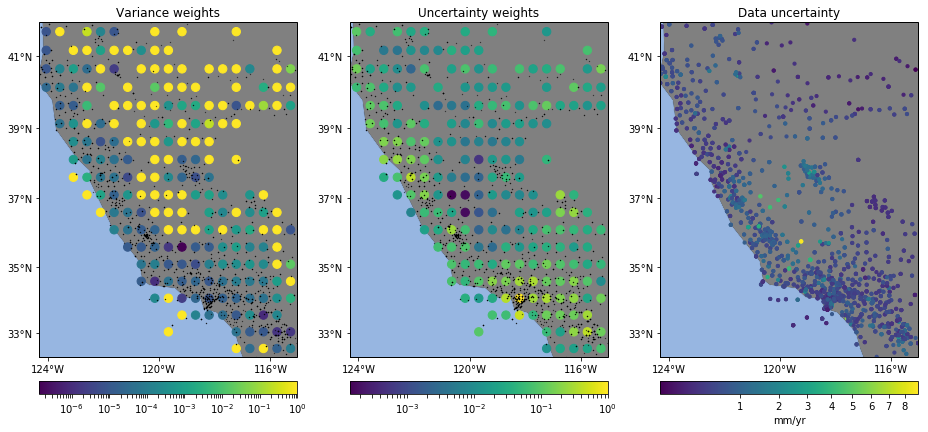

In [5]:
def setup_map(ax, title):
    ax.set_title(title)
    # Plot the land as a solid color
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='gray')
    ax.add_feature(cfeature.OCEAN)
    ax.set_extent(vd.get_region(coordinates), crs=crs)
    # Set the proper ticks for a Cartopy map
    ax.set_xticks(np.arange(-124, -115, 4), crs=crs)
    ax.set_yticks(np.arange(33, 42, 2), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())


# Now we can plot the different weights side by side on Mercator maps
fig, axes = plt.subplots(1, 3, figsize=(13, 7),
                         subplot_kw=dict(projection=ccrs.Mercator()))
titles = ['Variance weights', 'Uncertainty weights']
crs = ccrs.PlateCarree()
for ax, title, w in zip(axes[:2], titles, (weights_var, weights_uncert)):
    setup_map(ax, title)
    ax.plot(*coordinates, '.k', transform=crs, markersize=0.5)
    # Plot the weights
    pc = ax.scatter(*block_coords, c=w, s=70, transform=crs,
                    norm=LogNorm())
    plt.colorbar(pc, ax=ax, orientation='horizontal', pad=0.05)
ax = axes[2]
setup_map(ax, 'Data uncertainty')
pc = ax.scatter(*coordinates, c=data.std_up*1000, s=10, transform=crs,
                norm=PowerNorm(gamma=1/2))
cb = plt.colorbar(pc, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label('mm/yr')

plt.tight_layout()
plt.show()


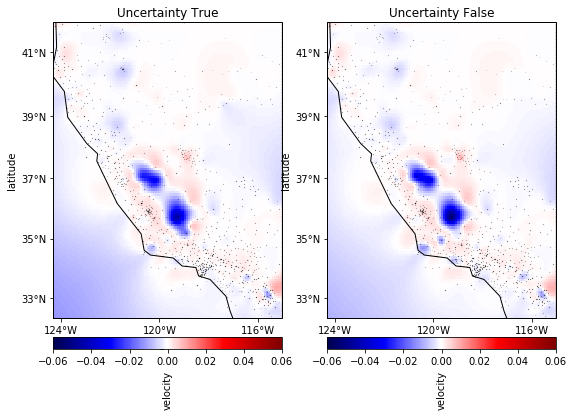

In [32]:
spa = 5/60
proj_coords = projection(*coordinates)

fig, axes = plt.subplots(1, 2, figsize=(9, 7),
                         subplot_kw=dict(projection=ccrs.Mercator()))
for uncertainty, damp, ax in zip([True, False], [1e-10, 1e-9], axes):
    chain = vd.Chain([('mean', vd.BlockMean(spa*111e3, uncertainty=uncertainty)),
                      ('spline', vd.Spline(damping=damp))])
    chain.fit(proj_coords, data.velocity_up, weights)
    grid = chain.grid(vd.get_region(coordinates), spacing=spa, projection=projection,
                      dims=['latitude', 'longitude'], data_names=['velocity'])
    grid.velocity.plot.pcolormesh(ax=ax, transform=crs, vmin=-0.06, vmax=0.06, cmap='seismic', 
                                 cbar_kwargs=dict(orientation='horizontal', pad=0.05))
    ax.plot(*coordinates, '.k', transform=crs, markersize=0.1)
    ax.coastlines()    
    setup_map(ax, 'Uncertainty {}'.format(uncertainty))